In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os
import seaborn as sns
import random 
import dask
import babet as bb
from moarpalettes import get_palette

sns.set_theme(style="white")
sns.set_style("white")

random.seed(10)
# inidates = ['2023-10-11', '2023-10-15', '2023-10-17']
inidates = ['2023-10-11', '2023-10-13', '2023-10-15', '2023-10-17']
experiments = ['pi', 'curr', 'incr']

dask.config.set(**{'array.slicing.split_large_chunks': True})

In [2]:
aberdeen = [-4, -2, 55.5, 57.5]
uk = [-10.5, 9.5, 45.5, 61.3] # longitude min, longitude max, latitude min, latitude max

def bootstrap_sample(data, n_iterations=100):
    """Bootstrap resampling with replacement.""" 
    means = np.array([
        np.mean(np.random.choice(data, size=len(data), replace=True))
        for _ in range(n_iterations)
    ])
    return np.percentile(means, [2.5, 97.5])  # 95% confidence interval

In [3]:
def calc_precip_scaling(t2m, tp, latitude_name = 'latitude', longitude_name = 'longitude', climate='1950'):
    """
    Function to calculate the scaling of precipitation with temperature. Averaging over area first

    Parameters
    ----------
    t2m : xarray DataArray
        Temperature data for the region of interest. Needs to have dimension climate.
    tp : xarray DataArray
        Precipitation data for the region of interest. Needs to have dimension climate.
    latitude_name : str
        Name of the latitude dimension in the DataArray. 
    longitude_name : str
        Name of the longitude dimension in the DataArray.
    climate : str, optional
        Climate scenario to compare against. The default is '1950'.

    Returns
    -------
    scaling_factor : xarray DataArray
        Scaling factor for precipitation with temperature.
    """
    
    # Calculate the mean temperature and precipitation
    mean_t2m = t2m.mean(dim=[latitude_name, longitude_name])
    mean_tp = tp.mean(dim=[latitude_name, longitude_name])

    # Calculate change in temperature over Aberdeenshire
    t2m_present = mean_t2m.sel(climate='present')
    t2m_climate = mean_t2m.sel(climate=climate)
    delta_t2m = t2m_present - t2m_climate

    # Calculate fractional precipitation change
    tp_present = mean_tp.sel(climate='present')
    tp_climate = mean_tp.sel(climate=climate)
    delta_tp = (tp_present - tp_climate)/tp_present

    # Calculate the scaling factor
    scaling_factor = delta_tp / delta_t2m
    return scaling_factor


In [5]:
color_palette = get_palette.classic_tab20().to_sn_palette()

In [6]:
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

# Load data and post-process

In [7]:
# ERA5 analogues
era5_analogues = bb.data.Data.get_era5_analogues()
era5_analogues_tp = era5_analogues['tp'].sel(lat=slice(aberdeen[3], aberdeen[2]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# RACMO analogues
racmo_msl, racmo_tp = bb.data.Data.get_racmo_analogues()
racmo_tp = racmo_tp['tp'].sel(lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# PGW 
pgw = bb.data.Data.get_pgw_ensemble()
pgw_tp = (((pgw.tp.sel(time=slice('2023-10-19 00', '2023-10-22 00'))*3*3600).sum(dim='time'))/1e5).sel(lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon'])

# FBA IFS
ifs = bb.data.Data.get_fba_ifs()
ifs_tp = ((ifs.tp.sel(time='2023-10-22 00') - ifs.tp.sel(time='2023-10-19 00'))*1000).sel(latitude=slice(aberdeen[3], aberdeen[2]), longitude=slice(aberdeen[0], aberdeen[1])).mean(dim=['latitude', 'longitude'])

# FBA MICAS
micas = bb.data.Data.get_fba_micas()
micas_tp = (micas.tp.sel(time=slice('2023-10-19 12', '2023-10-21 12'), lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).sum(dim='time')*24*3600).mean(dim=['lat', 'lon'])

Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file
Importing data from pre-existing file


In [8]:
racmo_msl, racmo_tp = bb.data.Data.get_racmo_indiv_analogues()

racmo_analogues_tp = racmo_tp.sel(lat=slice(aberdeen[2], aberdeen[3]), lon=slice(aberdeen[0], aberdeen[1])).mean(dim=['lat', 'lon']).tp

Importing data from pre-existing file


In [9]:
# # For uncertainty estimates, we need the individual analogues from RACMO
# racmo_individual_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_RACMO_2023-10-20_pr_individual_analogs_SCOT_1991-2020__1951-1980.nc')

# da = racmo_individual_analogues.sel(period='1951-1980')
# group = (np.arange(da.sizes['time']) // 16)
# tmp1= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['1950']})

# da = racmo_individual_analogues.sel(period='1991-2020')
# group = (np.arange(da.sizes['time']) // 16)
# tmp2= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['present']})

# racmo_individual_analogues = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/RACMO_analogues/analogs_RACMO_2023-10-20_pr_individual_analogs_SCOT_2071-2100__1991-2020.nc')
# da = racmo_individual_analogues.sel(period='2071-2100')
# group = (np.arange(da.sizes['time']) // 16)
# tmp3= da.groupby(xr.DataArray(group, dims='time')).mean('time').precip.expand_dims({'climate': ['future1']})
# racmo_analogues_tp = xr.concat([tmp1, tmp2, tmp3], dim='climate')


# Global temperatures differences

In [10]:
# ERA5
era5_globalmean_past = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_mean_fields/ERA_t2m_past.nc').mean(dim=['lat', 'lon'])
era5_globalmean_present = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/ERA5_mean_fields/ERA_t2m_prst.nc').mean(dim=['lat', 'lon'])

era5_diff_t2m = era5_globalmean_past.t2m - era5_globalmean_present.t2m # 1950 to present difference only

In [11]:
# ACCESS MICAS
access_globalmean_past = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/ts_1850-1900.nc').mean(dim=['lat', 'lon', 'month']).squeeze()
access_globalmean_present = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/ts_2011-2030.nc').mean(dim=['lat', 'lon', 'month']).squeeze()
access_globalmean_future = xr.open_dataset('/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/access-micas/ts_2048-2067.nc').mean(dim=['lat', 'lon', 'month']).squeeze()

access_diff_past = access_globalmean_past.ts - access_globalmean_present.ts
access_diff_future = access_globalmean_future.ts - access_globalmean_present.ts 

access_diff_ts = xr.DataArray(
    data=[access_diff_past, 0, access_diff_future],
    dims=['climate'],
    coords={'climate': ['1870', 'present', 'future1']}
)

In [12]:
# PGW -- temperature difference the same in all ensemble members
pgw_diff_t2m = xr.DataArray(
    data=[-1.5, 0, 1.5, 3],
    dims=['climate'],
    coords={'climate': ['1870', 'present', 'future1', 'future2']}
)

In [13]:
# IFS
ifs_glob = bb.data.Data.get_global_ifs().sel(time=slice('2023-10-19 00', '2023-10-22 00')).mean(dim=['time', 'latitude', 'longitude'])
ifs_diff_t2m = ifs_glob.t2m - ifs_glob.t2m.sel(climate='present')

/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi_1950/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/pi_1950/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/curr/GLO100/sfc/pf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/incr/GLO100/sfc/cf/*.nc
/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/incr/GLO100/sfc/pf/*.nc


In [14]:
# RACMO
racmo_diff_t2m = xr.DataArray(
    data=[-0.6568695208333324, 0, 1.6698919999999955, 3.124064645833334],
    dims=['climate'],
    coords={'climate': ['1950', 'present', 'future1', 'future2']}
)

In [15]:
# Probabilistic
prob_diff_t2m = xr.DataArray(
    data=[-1.5, 1.5],
    dims=['climate'],
    coords={'climate': ['1870', 'future1']}
)

# Testing different calculations

In [38]:
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using local ABD temperatures")
print(scaling_factors)

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invali

Precipitation scaling using local ABD temperatures
{'1870': array([[            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [18]:
# Slice latitude and longitude just once
region_t2m = ifs.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'))
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using UK temperatures")
print(scaling_factors)

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Precipitation scaling using UK temperatures
{'1870': array([[            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
 

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [19]:
ifs_ = bb.data.Data.get_fba_ifs()
starttime = '2023-10-19 00'
endtime = '2023-10-22 00'

# Slice latitude and longitude just once
region_t2m = ifs_.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')
region_tp = ifs_.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')

# Define list of climates to compare against 'present'
climates = ['1870', '1950', 'future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using European temperatures")
print(scaling_factors)

Precipitation scaling using European temperatures
{'1870': array([-0.00599752,  0.11058202], dtype=float32), '1950': array([0.08676349, 0.10668422], dtype=float32), 'future1': array([0.33301085, 0.12450784], dtype=float32)}


In [20]:
# Load gloabl data
glob_dir = '/gf5/predict/AWH019_ERMIS_ATMICP/Babet/DATA/MED-R/EXP/{}/GLO100/sfc/pf'
glob_file_dir = {'curr': glob_dir.format('curr'),
            'pi': glob_dir.format('pi'),
            'incr': glob_dir.format('incr')}
climates = ['1870', 'present', 'future1']
tmp = []
for e, exp in enumerate(['pi', 'curr', 'incr']):
    tmp.append(xr.open_mfdataset(os.path.join(glob_file_dir[exp], '*.nc'), preprocess=bb.data.Data.preproc_ds, engine='netcdf4').expand_dims(climate=[climates[e]]))
ifs_glob = xr.concat(tmp, dim='climate')

In [21]:
# Slice latitude and longitude just once
region_t2m = ifs_glob.t2m.sel(inidate=slice('2023-10-15', '2023-10-17'), time=slice(starttime, endtime)).mean(dim='time')
region_tp = ifs.tp.sel(latitude=slice(aberdeen[3], aberdeen[2]),
                       longitude=slice(aberdeen[0], aberdeen[1])).sel(inidate=slice('2023-10-15', '2023-10-17'))

# Define list of climates to compare against 'present'
climates = ['1870','future1']

# Use dictionary comprehension, compute after loop to maximize parallelism
scaling_factors = {
    climate: calc_precip_scaling(region_t2m, region_tp, climate=climate).mean('number').values
    for climate in climates
}

# Compute all at once (parallelized if using Dask)
from dask import compute
computed_values = compute(*scaling_factors.values())
scaling_factors = dict(zip(climates, computed_values))

print("Precipitation scaling using global temperatures")
print(scaling_factors)

/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: divide by zero encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))
/home/e/ermis/nobackups/miniforge3/envs/babet-3-7-12_new/lib/python3.7/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


Precipitation scaling using global temperatures
{'1870': array([[            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan],
       [            nan,             nan

In [54]:
# method 3
bootstrap_past = [np.mean(np.random.choice(era5_analogues_tp.sel(climate='1950'), size=len(era5_analogues_tp.sel(climate='1950').values), replace=True)) for _ in range(100)]
bootstrap_present = [np.mean(np.random.choice(era5_analogues_tp.sel(climate='present'), size=len(era5_analogues_tp.sel(climate='present').values), replace=True)) for _ in range(100)]
bootstrap_scaling = (np.array(bootstrap_past) - np.array(bootstrap_present))/np.array(bootstrap_present)/era5_diff_t2m.values
bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])
print("95% CI: ", bootstrap_scaling)

95% CI:  [-0.22356654  0.36847528]


## Testing different bootstrap methods

In [53]:
# method 2
bootstrap_past = np.random.choice(era5_analogues_tp.sel(climate='1950'), size=10000, replace=True)
bootstrap_present = np.random.choice(era5_analogues_tp.sel(climate='present'), size=10000, replace=True)
bootstrap_scaling = (bootstrap_past - bootstrap_present)/bootstrap_present/era5_diff_t2m.values
bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])
print("95% CI: ", bootstrap_scaling)

95% CI:  [-28.4268322    0.98040164]


# Precipitation scaling using global temperatures

## ERA5 analogues

In [59]:
def bootstrap_scaling_3(counterfac, factual, diff_t2m, n=10000):
        bootstrap_past = [np.mean(np.random.choice(counterfac, size=len(counterfac.values), replace=True)) for _ in range(n)]
        bootstrap_present = [np.mean(np.random.choice(factual, size=len(factual.values), replace=True)) for _ in range(n)]
        bootstrap_scaling = (np.array(bootstrap_past) - np.array(bootstrap_present))/np.array(bootstrap_present)/diff_t2m.values
        bootstrap_scaling = np.percentile(bootstrap_scaling, [2.5, 97.5])

        return bootstrap_scaling

In [60]:
# ERA5 analogues
tp_diff = (era5_analogues_tp.sel(climate='1950') - era5_analogues_tp.sel(climate='present')).mean()/era5_analogues_tp.sel(climate='present').mean()
precip_scaling = tp_diff/era5_diff_t2m

print("ERA5 precip scaling")
print("Mean: ", precip_scaling.values)

# method 3
bootstrap_scaling = bootstrap_scaling_3(era5_analogues_tp.sel(climate='1950'), era5_analogues_tp.sel(climate='present'), era5_diff_t2m, n=10000)
print("95% CI: ", bootstrap_scaling)

# Create pandas daaframe
scaling_df = pd.DataFrame({"method": ["ERA5"], 
                           "climate": ["1950"],
                            "scaling": [precip_scaling.values], 
                            "lower": [bootstrap_scaling[0]], 
                            "upper": [bootstrap_scaling[1]]})

ERA5 precip scaling
Mean:  0.12216272
95% CI:  [-0.25149387  0.37424404]


## IFS

In [61]:
# IFS 
lead_times = ["long lead time", "short lead time"]
for i, ini in enumerate(['2023-10-15', '2023-10-17']):
    lead_time = lead_times[i]
    for e, exp in enumerate(['1870', '1950', 'future1']):
        counterfac = ifs_tp.sel(inidate=ini, climate=exp).compute()
        factual = ifs_tp.sel(inidate=ini, climate='present').compute()
        
        tp_diff = (counterfac - factual).mean()/factual.mean()
        precip_scaling = tp_diff/ifs_diff_t2m.sel(climate=exp, inidate=ini).mean()
        print("IFS, Inidate: ", ini, ", climate: ", exp)
        print("Mean: ", precip_scaling.values)
        
        # method 3
        bootstrap_scaling = bootstrap_scaling_3(counterfac, factual, ifs_diff_t2m.sel(climate=exp, inidate=ini).mean().compute(), n=10000)
        print("95% CI: ", bootstrap_scaling)

        # Add to pandas dataframe
        scaling_df = pd.concat([scaling_df, pd.DataFrame({"method": ["FBA IFS"+", " + lead_time], 
                                                           "climate": [exp],
                                                           "scaling": [precip_scaling.values], 
                                                           "lower": [bootstrap_scaling[0]], 
                                                           "upper": [bootstrap_scaling[1]]})], ignore_index=True)

IFS, Inidate:  2023-10-15 , climate:  1870
Mean:  -0.036932938
95% CI:  [-0.27614615  0.15950518]
IFS, Inidate:  2023-10-15 , climate:  1950
Mean:  -0.08055056
95% CI:  [-0.37701306  0.17517525]
IFS, Inidate:  2023-10-15 , climate:  future1
Mean:  0.06844049
95% CI:  [-0.0716481   0.24565536]
IFS, Inidate:  2023-10-17 , climate:  1870
Mean:  0.14801796
95% CI:  [0.02967302 0.25307303]
IFS, Inidate:  2023-10-17 , climate:  1950
Mean:  0.11781483
95% CI:  [-0.03395384  0.25574274]
IFS, Inidate:  2023-10-17 , climate:  future1
Mean:  0.04829093
95% CI:  [-0.02781298  0.13069893]


In [62]:
# PGW 
for exp in ['1870', 'future1', 'future2']:
    tp_diff = (pgw_tp.sel(climate=exp) - pgw_tp.sel(climate='present')).mean()/pgw_tp.sel(climate='present').mean()
    precip_scaling = tp_diff/pgw_diff_t2m.sel(climate=exp).mean()
    print("PGW, climate: ", exp)
    print("Mean: ", precip_scaling.values)

    bootstrap_scaling = bootstrap_scaling_3(pgw_tp.sel(climate=exp), pgw_tp.sel(climate='present'), pgw_diff_t2m.sel(climate=exp), n=10000)
    print("95% CI: ", bootstrap_scaling)

    # Add to pandas dataframe  
    scaling_df = pd.concat([scaling_df, pd.DataFrame({"method": ["PGW"], 
                                                       "climate": [exp],
                                                       "scaling": [precip_scaling.values], 
                                                       "lower": [bootstrap_scaling[0]], 
                                                       "upper": [bootstrap_scaling[1]]})], ignore_index=True)

PGW, climate:  1870
Mean:  0.07078162332375844
95% CI:  [-0.04484147  0.16940378]
PGW, climate:  future1
Mean:  0.06581826508045197
95% CI:  [-0.03051845  0.18590534]
PGW, climate:  future2
Mean:  0.074497585495313
95% CI:  [0.0255417  0.13886197]


In [63]:
# ACCESS MICAS
for exp in ['1870', 'future1']:
    tp_diff = (micas_tp.sel(climate=exp) - micas_tp.sel(climate='present')).mean()/micas_tp.sel(climate='present').mean()
    precip_scaling = tp_diff/access_diff_ts.sel(climate=exp).mean()
    print("MICAS, climate: ", exp)
    print("Mean: ", precip_scaling.values)

    bootstrap_scaling = bootstrap_scaling_3(micas_tp.sel(climate=exp), micas_tp.sel(climate='present'), access_diff_ts.sel(climate=exp), n=10000)
    print("95% CI: ", bootstrap_scaling)

    # Add to pandas dataframe
    scaling_df = pd.concat([scaling_df, pd.DataFrame({"method": ["FBA ACCESS MICAS"],
                                                       "climate": [exp],
                                                       "scaling": [precip_scaling.values],
                                                       "lower": [bootstrap_scaling[0]],
                                                       "upper": [bootstrap_scaling[1]]})], ignore_index=True)

MICAS, climate:  1870
Mean:  -0.05939192156910914
95% CI:  [-0.37019916  0.16447287]
MICAS, climate:  future1
Mean:  0.09515207082423581
95% CI:  [-0.08530456  0.33880556]


In [64]:
# RACMO analogues
for e, exp in enumerate(['1950', 'future1', 'future2']):
    # tp_diff = (racmo_tp.sel(climate=exp) - racmo_tp.sel(climate='present'))/racmo_tp.sel(climate='present')
    # precip_scaling = tp_diff/racmo_diff_t2m.sel(climate=exp).mean()
    tp_diff = (racmo_analogues_tp.sel(climate=exp) - racmo_analogues_tp.sel(climate='present')).mean()/racmo_analogues_tp.sel(climate='present').mean()
    precip_scaling = tp_diff/racmo_diff_t2m.sel(climate=exp).mean()
    print("RACMO, climate: ", exp)
    print("Mean: ", precip_scaling.values)

    bootstrap_scaling = bootstrap_scaling_3(racmo_analogues_tp.sel(climate=exp), racmo_analogues_tp.sel(climate='present'), racmo_diff_t2m.sel(climate=exp), n=10000)
    print("95% CI: ", bootstrap_scaling)

    # Add to pandas dataframe
    scaling_df = pd.concat([scaling_df, pd.DataFrame({"method": ["RACMO analogues"], 
                                                       "climate": [exp],
                                                       "scaling": [precip_scaling.values], 
                                                       "lower": [bootstrap_scaling[0]], 
                                                       "upper": [bootstrap_scaling[1]]})], ignore_index=True)

RACMO, climate:  1950
Mean:  0.08270570737180019
95% CI:  [-0.08217613  0.23805072]
RACMO, climate:  future1
Mean:  0.012045760129258832
95% CI:  [-0.05085539  0.0812908 ]
RACMO, climate:  future2
Mean:  0.020989239245454188
95% CI:  [-0.00889086  0.05319674]


In [84]:
# Probabilistic 
probabilistic_df = pd.DataFrame({"method": ["Probabilistic"]*2,
                                 "climate": ["1870", "future1"],
                                 "scaling": [0.0719, 0.0196], 
                                 "lower": [-0.1106, -0.0369], 
                                 "upper": [0.3103, 0.0743]})

scaling_df = pd.concat([scaling_df, probabilistic_df], ignore_index=True)

# Results from all methods

In [16]:
# Save data frame as csv
# save_df = scaling_df.copy()
# save_df.to_csv('../data/13_precip_scaling_factors.csv', index=False)

# Load data frame
save_df = pd.read_csv('../data/13_precip_scaling_factors.csv')

In [34]:
save_df['method'] = save_df['method'].replace('ERA5', 'ERA5 analogues')
save_df['method'] = save_df['method'].replace('FBA ACCESS MICAS', 'FBA ACCESS-MICAS')

In [35]:
save_df

,method,climate,scaling,lower,upper
0,ERA5 analogues,1950,0.122163,-0.251494,0.374244
1,"FBA IFS, long lead time",1870,-0.036933,-0.276146,0.159505
2,"FBA IFS, long lead time",1950,-0.080551,-0.377013,0.175175
3,"FBA IFS, long lead time",future1,0.068440,-0.071648,0.245655
4,"FBA IFS, short lead time",1870,0.148018,0.029673,0.253073
5,"FBA IFS, short lead time",1950,0.117815,-0.033954,0.255743
6,"FBA IFS, short lead time",future1,0.048291,-0.027813,0.130699
7,PGW,1870,0.070782,-0.044841,0.169404
8,PGW,future1,0.065818,-0.030518,0.185905
9,PGW,future2,0.074498,0.025542,0.138862


In [17]:
# Sort method by euclidean distance
methods_order = ['PGW', 'FBA IFS, short lead time', 'FBA IFS, long lead time', 'FBA ACCESS MICAS','RACMO analogues', 'ERA5', 'Probabilistic']
save_df['method'] = pd.Categorical(save_df['method'], categories=methods_order, ordered=True)
save_df = save_df.sort_values('method')

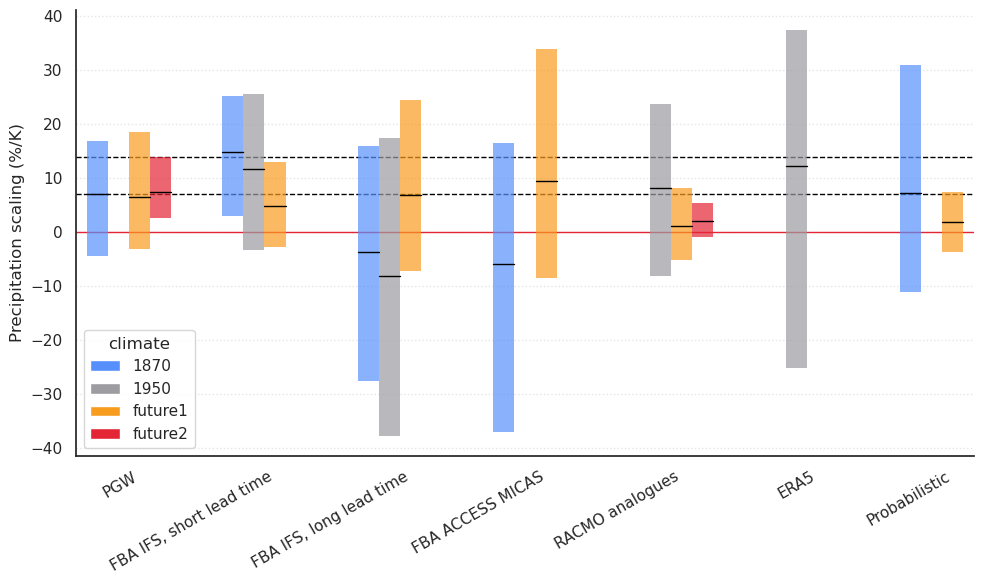

In [19]:
fig, ax = plt.subplots(figsize=(10, 6))
# Setup
climates = ['1870', '1950', 'future1', 'future2']
methods = save_df['method'].unique()
climate_colors = {
    '1870': color_palette[0], 
    '1950': color_palette[4],
    'future1':  color_palette[1],
    'future2':  color_palette[2]
}

box_data = []
positions = []
colors = []

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

# Create bxp-compatible dicts
spacing = 1.2  # space between method groups
width = 0.5  # offset for each climate in a group

for i, method in enumerate(methods):
    for j, climate in enumerate(climates):
        row = save_df[(save_df['method'] == method) & (save_df['climate'] == climate)]
        if row.empty:
            continue
        row = row.iloc[0]
        box_data.append({
            # 'label': f'{method}_{climate}',  # optional for display
            'med': row['scaling']*100,
            'q1': row['lower']*100,
            'q3': row['upper']*100,
            'whislo': 0,
            'whishi': 0,
            'fliers': []
        })
        pos = width * (i * len(climates) + j) + spacing * i  # spaced by group
        positions.append(pos)
        colors.append(climate_colors[climate])

# Plot
boxplot = ax.bxp(box_data, 
                 positions=positions, 
                 showfliers=False, 
                 patch_artist=True,
                 showcaps=False, 
                 whiskerprops={'linestyle': ''}, 
                 medianprops={'linestyle': '-', 'color': 'black'}, 
                 boxprops={'linestyle': '', 'alpha': 0.7})

# Color boxes
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Ticks
ax.set_xticks([np.mean([i*len(climates)*width+i*spacing,(i+1)*len(climates)*width+i*spacing]) for i in range(len(methods))])
ax.set_xticklabels(methods, rotation=30, ha='right')

# Labels and formatting
plt.ylabel("Precipitation scaling (%/K)")
plt.grid(axis='y', linestyle=':', alpha=0.5)
sns.despine()
plt.tight_layout()

# Optional: add a custom legend
from matplotlib.patches import Patch
legend_patches = [Patch(facecolor=climate_colors[c], label=c) for c in climates]
plt.legend(handles=legend_patches, title="climate", loc="lower left")



In [56]:
color_palette

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

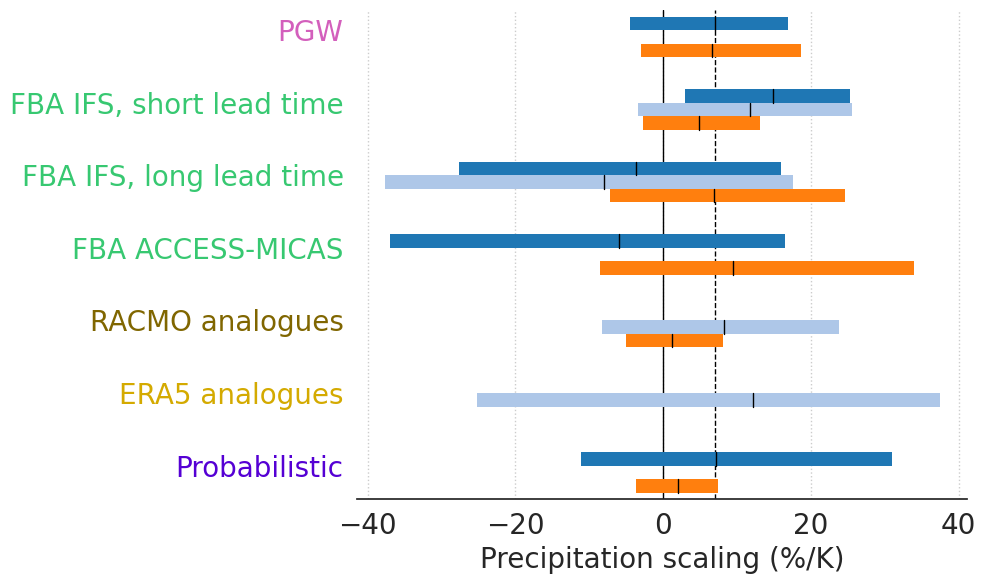

In [57]:
from tkinter import font
from numpy import size


fig, ax = plt.subplots(figsize=(10, 6))
# Setup
climates = np.flip(['1870', '1950', 'future1'])
methods = np.flip(['PGW', 'FBA IFS, short lead time', 'FBA IFS, long lead time', 'FBA ACCESS-MICAS','RACMO analogues', 'ERA5 analogues', 'Probabilistic'])
climate_colors = {
    '1870': color_palette[0], 
    '1950': color_palette[1],
    'future1':  color_palette[2],
    'future2':  color_palette[6]
}

box_data = []
positions = []
colors = []

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axvline(x=7, color='black', linestyle='--', linewidth=1)
# plt.axvline(x=14, color='black', linestyle='--', linewidth=1)
plt.axvline(x=0, color='black', linestyle='-', linewidth=1)

colors_methods = ['#d35fbc', '#37c871', '#37c871', '#37c871','#806600ff',  '#d4aa00ff', '#5500d4ff'] # pgw, ifs short, ifs long, micas, racmo, era5, probabilistic

# Create bxp-compatible dicts
spacing = 1.2  # space between method groups
width = 0.5  # offset for each climate in a group

for i, method in enumerate(methods):
    for j, climate in enumerate(climates):
        row = save_df[(save_df['method'] == method) & (save_df['climate'] == climate)]
        if row.empty:
            continue
        row = row.iloc[0]
        box_data.append({
            # 'label': f'{method}_{climate}',  # optional for display
            'med': row['scaling']*100,
            'q1': row['lower']*100,
            'q3': row['upper']*100,
            'whislo': 0,
            'whishi': 0,
            'fliers': []
        })
        pos = width * (i * len(climates) + j) + spacing * i  # spaced by group
        positions.append(pos)
        colors.append(climate_colors[climate])


# Plot
boxplot = ax.bxp(box_data, 
                 positions=positions, 
                 showfliers=False, 
                 patch_artist=True,
                 showcaps=False, 
                 whiskerprops={'linestyle': ''}, 
                 medianprops={'linestyle': '-', 'color': 'black'}, 
                 boxprops={'linestyle': ''}, 
                 vert=False)

# Color boxes
for patch, color in zip(boxplot['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(1)

# Ticks
ax.set_yticks([np.mean([i*len(climates)*width+i*spacing,(i+1)*len(climates)*width+i*spacing]) for i in range(len(methods))])
ax.set_yticklabels(methods, ha='right')
# Set x-ticks at intervals of 20
plt.xticks(np.arange(-40, 60, 20), size=20)

# Apply colors to y tick labels based on methods 
for ticklabel, color in zip(ax.get_yticklabels(), colors_methods[::-1]):
    ticklabel.set_color(color)

# Labels and formatting
plt.xlabel("Precipitation scaling (%/K)", size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.grid(axis='x', linestyle=':')
sns.despine(left=True)
plt.tight_layout()

# Optional: add a custom legend
from matplotlib.patches import Patch
# legend_patches = [Patch(facecolor=climate_colors[c], label=c) for c in climates]
# plt.legend(handles=legend_patches, title="climate", fontsize=20, title_fontsize=20, bbox_to_anchor=(0.8, 1)) # loc="upper right",

plt.savefig("figures/PAPER4_precip_scaling_boxplot.png", dpi=600, bbox_inches='tight')
plt.savefig("figures/PAPER4_precip_scaling_boxplot.pdf")

# HEX codes

In [42]:

# convert to hex "rrggbbaa"
hex_colors = [
    '{:02x}{:02x}{:02x}'.format(
        int(r*255), int(g*255), int(b*255)
    )
    for r, g, b in color_palette
]

print(hex_colors)

['1f77b4', 'aec7e8', 'ff7f0e', 'ffbb78', '2ca02c', '98df8a', 'd62728', 'ff9896', '9467bd', 'c5b0d5', '8c564b', 'c49c94', 'e377c2', 'f7b6d2', '7f7f7f', 'c7c7c7', 'bcbd22', 'dbdb8d', '17becf', '9edae5']


In [51]:
[climate_colors.values()]

[dict_values([(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), (0.6823529411764706, 0.7803921568627451, 0.9098039215686274), (1.0, 0.4980392156862745, 0.054901960784313725), (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)])]

# Different order

Text(0.5, 1.0, 'ordered by decreasing conditioning')

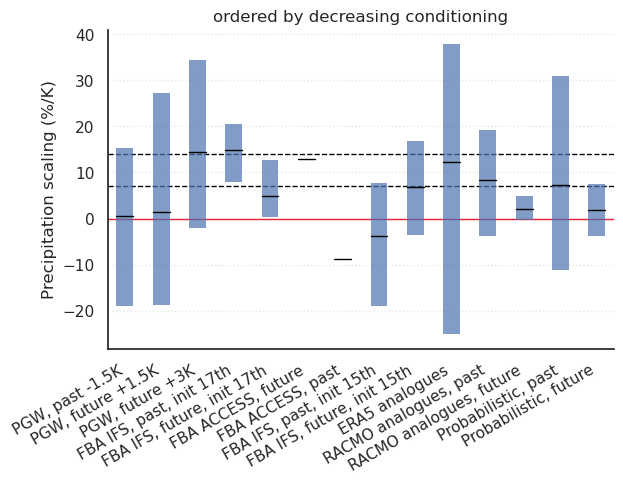

In [49]:
from matplotlib import colors

stats = [{'med': 0.57, 'q1': -18.96, 'q3': 15.21, 'whislo' : 0, 'whishi': 0},  # PGW past
         {'med': 1.36, 'q1': -18.67, 'q3': 27.19, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
         {'med': 14.533, 'q1': -2.10, 'q3': 34.4, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
         {'med': 14.80, 'q1': 7.83, 'q3': 20.50, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
         {'med': 4.83, 'q1': 0.31, 'q3': 12.81, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
         {'med': 12.9, 'q1': 12.9, 'q3': 12.9, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, future
         {'med': -8.7, 'q1': -8.7, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, past
         {'med': -3.69, 'q1': -18.97, 'q3': 7.71, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
         {'med': 6.84, 'q1': -3.51, 'q3': 16.94, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
         {'med': 12.21, 'q1': -25.11, 'q3': 37.87, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
         {'med': 8.26, 'q1': -3.77, 'q3': 19.2, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, past
         {'med': 2.14, 'q1': -0.32, 'q3': 4.84, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, future
         {'med': 7.19, 'q1': -11.06, 'q3': 31.03, 'whislo' : 0, 'whishi': 0},   # Probabilistic past
         {'med': 1.96, 'q1': -3.69, 'q3': 7.43, 'whislo' : 0, 'whishi': 0}] # Probabilistic future

# To help with plotting
labels = ['PGW, past -1.5K', 'PGW, future +1.5K', 'PGW, future +3K', 
          'FBA IFS, past, init 17th', 'FBA IFS, future, init 17th', 
          'FBA ACCESS, future', 'FBA ACCESS, past', 
          'FBA IFS, past, init 15th', 'FBA IFS, future, init 15th',
          'ERA5 analogues', 
          'RACMO analogues, past', 'RACMO analogues, future',
          'Probabilistic, past', 'Probabilistic, future']
positions = np.linspace(0, len(stats), len(stats))

# Main plot
_, ax = plt.subplots();

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

boxplot = ax.bxp(stats, showfliers=False, 
              showcaps=False, 
              whiskerprops={'linestyle': ''}, 
              medianprops={'linestyle': '-', 'color': 'black'}, 
              boxprops={'linestyle': '', 'alpha': 0.7},
              patch_artist=True,
              positions=positions);

# Plot settings
plt.ylabel("Precipitation scaling (%/K)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha='right')
sns.despine()
plt.tight_layout()
# Add a faint grid in dotted lines
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('ordered by decreasing conditioning')

Text(0.5, 1.0, 'ordered by future and past')

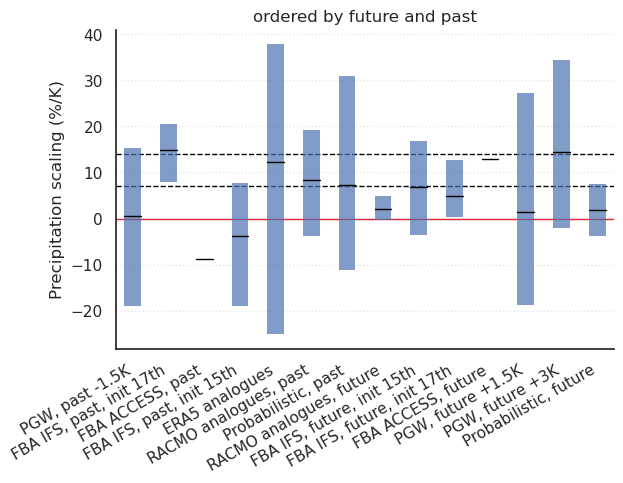

In [54]:
from matplotlib import colors

stats = [{'med': 0.57, 'q1': -18.96, 'q3': 15.21, 'whislo' : 0, 'whishi': 0},  # PGW past
         {'med': 14.80, 'q1': 7.83, 'q3': 20.50, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 17
         {'med': -8.7, 'q1': -8.7, 'q3': -8.7, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, past
         {'med': -3.69, 'q1': -18.97, 'q3': 7.71, 'whislo' : 0, 'whishi': 0},  # FBA IFS, past, 15
         {'med': 12.21, 'q1': -25.11, 'q3': 37.87, 'whislo' : 0, 'whishi': 0},  # ERA5 analogues
         {'med': 8.26, 'q1': -3.77, 'q3': 19.2, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, past
         {'med': 7.19, 'q1': -11.06, 'q3': 31.03, 'whislo' : 0, 'whishi': 0},   # Probabilistic past
         {'med': 2.14, 'q1': -0.32, 'q3': 4.84, 'whislo' : 0, 'whishi': 0},  # RACMO analogues, future
         {'med': 6.84, 'q1': -3.51, 'q3': 16.94, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 15
         {'med': 4.83, 'q1': 0.31, 'q3': 12.81, 'whislo' : 0, 'whishi': 0},  # FBA IFS, fut, 17
         {'med': 12.9, 'q1': 12.9, 'q3': 12.9, 'whislo' : 0, 'whishi': 0},  # FBA ACCESS, future
         {'med': 1.36, 'q1': -18.67, 'q3': 27.19, 'whislo' : 0, 'whishi': 0},  # PGW FUT1
         {'med': 14.533, 'q1': -2.10, 'q3': 34.4, 'whislo' : 0, 'whishi': 0},  # PGW FUT2
         {'med': 1.96, 'q1': -3.69, 'q3': 7.43, 'whislo' : 0, 'whishi': 0}] # Probabilistic future

# To help with plotting
labels = ['PGW, past -1.5K', 
          'FBA IFS, past, init 17th', 'FBA ACCESS, past', 
          'FBA IFS, past, init 15th', 
          'ERA5 analogues', 
          'RACMO analogues, past', 
          'Probabilistic, past', 
          'RACMO analogues, future',
          'FBA IFS, future, init 15th',
          'FBA IFS, future, init 17th', 
          'FBA ACCESS, future',
          'PGW, future +1.5K', 'PGW, future +3K',
          'Probabilistic, future']
positions = np.linspace(0, len(stats), len(stats))

# Main plot
_, ax = plt.subplots();

# Horizontal line at 7 %/K and 14 %/K and 0
plt.axhline(y=7, color='black', linestyle='--', linewidth=1)
plt.axhline(y=14, color='black', linestyle='--', linewidth=1)
plt.axhline(y=0, color=color_palette[2], linestyle='-', linewidth=1)

boxplot = ax.bxp(stats, showfliers=False, 
              showcaps=False, 
              whiskerprops={'linestyle': ''}, 
              medianprops={'linestyle': '-', 'color': 'black'}, 
              boxprops={'linestyle': '', 'alpha': 0.7},
              patch_artist=True,
              positions=positions);

# Plot settings
plt.ylabel("Precipitation scaling (%/K)")
ax.set_xticks(positions)
ax.set_xticklabels(labels, rotation=30, ha='right')
sns.despine()
plt.tight_layout()
# Add a faint grid in dotted lines
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.title('ordered by future and past')